# Prueba Técnica Data Science

En Los Ángeles existe un sistema compartido de bicicletas que brinda datos anónimos acerca
del uso del servicio. La tabla que se proporciona contiene el histórico de viajes que se han
realizado desde 2016 y contiene una columna que es de particular interés y que se buscará
analizar a más profundidad: Passholder_type. A continuación se presentan las columnas
que contiene la tabla:

- trip_id: identificador único para el viaje
- duration: duración del viaje en minutos
- start_time: dia/hora donde en viaje inicia en formato ISO 8601 tiempo local
- end_time: dia/hora donde el viaje termina en formato ISO 8601 tiempo local
- start_station: la estación donde el viaje inició
- start_lat: la latitud de la estación donde el viaje se originó
- start_lon: la longitud de la estación donde el viaje se originó
- end_station: la estación donde el viaje terminó
- end_lat: la latitud de la estación donde terminó el viaje
- end_lon: la longitud de la estación donde terminó el viaje
- bike_id: un entero único que identifica la bicicleta
- plan_duration: número de días que el usuario tendrá el paso. 0 significa un viaje único (Walk-up plan)
- trip_route_category: “Round trip” son viajes que empiezan y terminan en la misma estación
- passholder_type: El nombre del plan de passholder

In [335]:
# Librerias para lectura y visualización de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Oversampling
from imblearn.over_sampling import SMOTE

# Librerias de Machine learning
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, make_scorer
from xgboost import XGBClassifier
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture

import joblib
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [336]:
# Lectura de datos
df = pd.read_csv('./train_set.csv')
df.head(3)

,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062


## EDA

### Time

In [524]:
df_eda = df.copy()

In [525]:
# Transformación de datos tipo fecha
df_eda['start_time'] = pd.to_datetime(df_eda['start_time'])
df_eda['end_time'] = pd.to_datetime(df_eda['end_time'])

# extracción de año, mes, día de la semana y  hora deldía
df_eda['year'] = df_eda['start_time'].dt.year
df_eda['month'] = df_eda['start_time'].dt.month
df_eda['day_of_week'] = df_eda['start_time'].dt.day_of_week
df_eda['hour_of_day'] = df_eda['start_time'].dt.hour

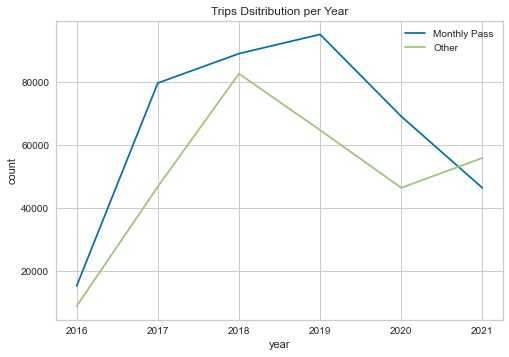

In [530]:
# Gráfica del uso de bicicletas en el tiempo
trip_per_month_Monthly = df_eda[df_eda['passholder_type'] == 'Monthly Pass'].groupby('year')['trip_id'].count().to_frame().reset_index()
trip_per_month_Monthly.columns = ['year', 'count']

trip_per_month_Other = df_eda[df_eda['passholder_type'] != 'Monthly Pass'].groupby('year')['trip_id'].count().to_frame().reset_index()
trip_per_month_Other.columns = ['year', 'count']


sns.lineplot(x = 'year', y = 'count', data = trip_per_month_Monthly, label = 'Monthly Pass')
sns.lineplot(x = 'year', y = 'count', data = trip_per_month_Other, label = 'Other')
plt.legend()
plt.title('Trips Dsitribution per Year')
plt.show()

En esta gráfica podemos observar que la tendencia del uso de membresías mensuales ha ido a la baja a apartir del año 2019, contrario a la tendencia alcista que se intuía. Por otro lado, el resto de membresías parecen estar en un periodo alcista. Sin embargo la caída en las subscripciones mensuales ha provocado en general una baja en eluso de bicicletas como se puede apreciar en la gráfica siguiente:

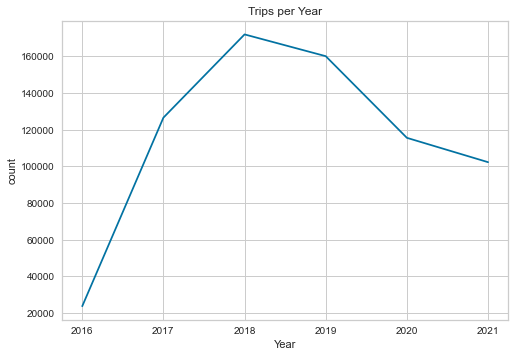

In [533]:
trips_per_year = df_eda.groupby('year')['trip_id'].count()
plt.plot(trips_per_year)
plt.title('Trips per Year')
plt.xlabel('Year')
plt.ylabel('count')
plt.show()

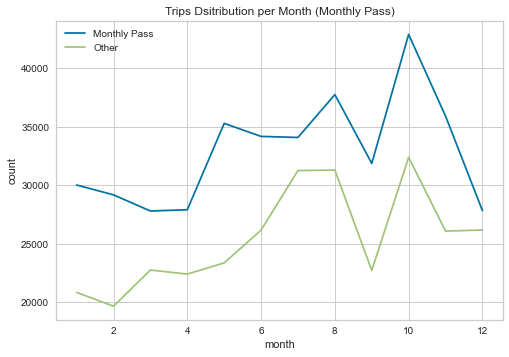

In [538]:
# Gráfica del uso de bicicletas por mes (Monthly Pass)
trip_per_month_M = df_eda[df_eda['passholder_type'] == 'Monthly Pass'].groupby('month')['trip_id'].count().to_frame().reset_index()
trip_per_month_M.columns = ['month', 'count']

trip_per_month_O = df_eda[df_eda['passholder_type'] != 'Monthly Pass'].groupby('month')['trip_id'].count().to_frame().reset_index()
trip_per_month_O.columns = ['month', 'count']

sns.lineplot(x = 'month', y = 'count', data = trip_per_month_M, label = 'Monthly Pass')
sns.lineplot(x = 'month', y = 'count', data = trip_per_month_O, label = 'Other')
plt.legend()
plt.title('Trips Dsitribution per Month (Monthly Pass)')
plt.show()

Podemos observar que ambas distribuciones son más o menos similares por lo que podemos intuir que el mes no tiene demasiada influencia en la elección del tipo de membresía. Excepto tal vez por el mes 5 donde vemos una ligera preferencia por aquellos que poseen una membresía mensual.

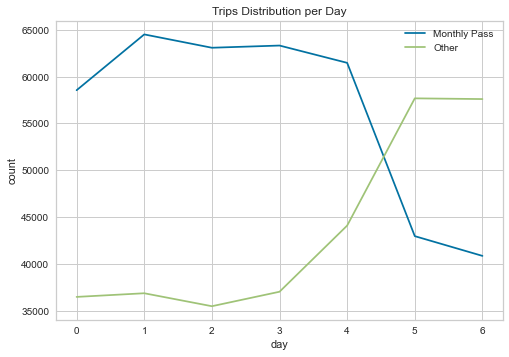

In [540]:
# Uso de bicicleta por día de la semana (Monthly)
trip_per_day_M = df_eda[df_eda['passholder_type'] == 'Monthly Pass'].groupby('day_of_week')['trip_id'].count().to_frame().reset_index()
trip_per_day_M.columns = ['day', 'count']

trip_per_day_O = df_eda[df_eda['passholder_type'] != 'Monthly Pass'].groupby('day_of_week')['trip_id'].count().to_frame().reset_index()
trip_per_day_O.columns = ['day', 'count']

sns.lineplot(x = 'day', y = 'count', data = trip_per_day_M, label = 'Monthly Pass')
sns.lineplot(x = 'day', y = 'count', data = trip_per_day_O, label = 'Other')
plt.title('Trips Distribution per Day')
plt.show()

En este caso si que puede observarse una tendencia en el comportamiento del uso de bicicleta entre aquellos con membresía mensual y los demás, aquellos con membresía mensual tienden a usar la bicicleta entre semana, mientras que aquellos con otro tipo de membresía suelen usarla los fines de semana, tal vez por recreación más que como un medio de transporte usual. Lo que puede sugerir que aquellos con una membresía mensual son personas que usan la bicicleta para transportarse al trabajo o la escuela, más que por diversión. 

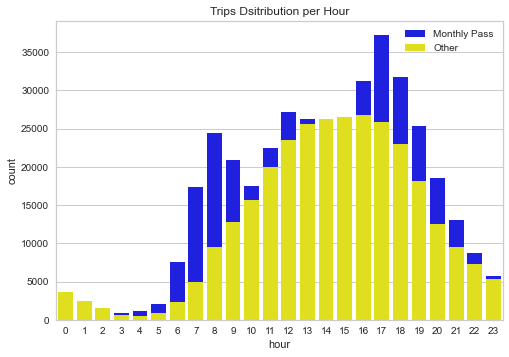

In [544]:
trip_per_hour_O = df_eda[df_eda['passholder_type'] != 'Monthly Pass'].groupby('hour_of_day')['trip_id'].count().to_frame().reset_index()
trip_per_hour_O.columns = ['hour', 'count']

trip_per_hour_M = df_eda[df_eda['passholder_type'] == 'Monthly Pass'].groupby('hour_of_day')['trip_id'].count().to_frame().reset_index()
trip_per_hour_M.columns = ['hour', 'count']

sns.barplot(x = 'hour', y = 'count', data = trip_per_hour_M, label = 'Monthly Pass', color = 'blue')
sns.barplot(x = 'hour', y = 'count', data = trip_per_hour_O, label = 'Other', color = 'yellow')
plt.legend()
plt.title('Trips Dsitribution per Hour')
plt.show()

En general se puede apreciar un comportamiento bastante similar en ambas categorías, las personas suelen usar la bicicleta entre las 11 de la mañana y las 6 de la tarde, esto se puede apreciar en la siguiente gráfica.

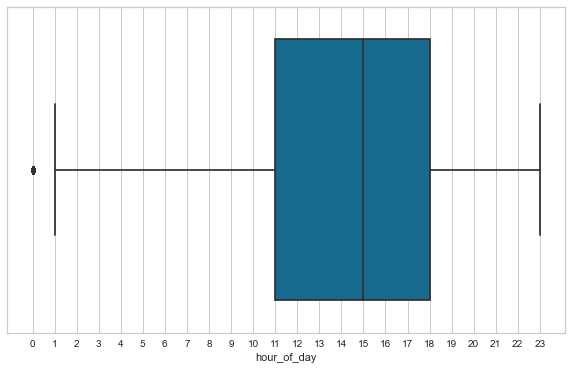

In [347]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'hour_of_day', data = df_eda)
plt.xticks(list(range(0, 24)))
plt.show()

### Location

In [546]:
df_eda.describe()

,trip_id,duration,start_lat,start_lon,end_lat,end_lon,plan_duration,start_station,end_station,year,month,day_of_week,hour_of_day
count,7.000000e+05,700000.000000,694437.000000,694437.000000,681426.000000,681426.000000,699792.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000,700000.000000
mean,1.069468e+08,37.084979,34.044952,-118.253849,34.044175,-118.259183,44.928697,3499.720464,3489.726771,2018.748306,6.773867,3.022640,14.127986
std,4.497342e+07,125.302510,0.325255,2.332640,0.299721,2.129781,92.816296,615.918795,613.040769,1.400052,3.355686,1.983241,4.646858
min,8.369648e+06,1.000000,33.710979,-118.495422,33.710979,-118.495422,0.000000,3000.000000,3000.000000,2016.000000,1.000000,0.000000,0.000000
25%,7.538051e+07,7.000000,34.037460,-118.280952,34.037048,-118.280952,1.000000,3031.000000,3030.000000,2018.000000,4.000000,1.000000,11.000000
50%,1.179410e+08,13.000000,34.046612,-118.256980,34.046520,-118.256981,30.000000,3064.000000,3064.000000,2019.000000,7.000000,3.000000,15.000000
75%,1.404178e+08,26.000000,34.051941,-118.247162,34.050911,-118.246422,30.000000,4214.000000,4214.000000,2020.000000,10.000000,5.000000,18.000000
max,1.794831e+08,1440.000000,55.705528,118.238258,55.705528,37.606541,999.000000,4594.000000,4594.000000,2021.000000,12.000000,6.000000,23.000000


En lat y lon existen algunas anomalías que pueden ser intercambiados por la información correcta. Y es que en la mayoría de los casos se tiene que la información faltante o incorrecta en cuanto la latitud y longitud, aparece de manera correcta en su contraparte, es decir,si faltan los valores en los puntos iniciales, se puede encontrar la información correcta en el punto final del trayecto.

In [547]:
df_eda[df_eda['start_station'] == 4496][['start_lat', 'start_lon', 'end_lat', 'end_lon']].describe()

,start_lat,start_lon,end_lat,end_lon
count,169.000000,169.000000,160.000000,160.000000
mean,53.648009,22.834424,45.112796,-38.457900
std,6.381435,45.816000,10.895048,78.235297
min,33.972980,-118.423943,33.958790,-118.471550
25%,55.705528,37.606541,33.976189,-118.418419
50%,55.705528,37.606541,55.705528,37.606541
75%,55.705528,37.606541,55.705528,37.606541
max,55.705528,37.606541,55.705528,37.606541


In [548]:
df_eda['start_lat'].where(df_eda['start_station'] != 4496, 33.972980, inplace = True)
df_eda['start_lon'].where(df_eda['start_station'] != 4496, 	-118.423943, inplace = True)
df_eda['end_lat'].where(df_eda['end_station'] != 4496, 33.972980, inplace = True)
df_eda['end_lon'].where(df_eda['end_station'] != 4496, 	-118.423943, inplace = True)

In [549]:
df_eda[df_eda['start_station'] == 3039][['start_lat', 'start_lon', 'end_lat', 'end_lon']].describe()

,start_lat,start_lon,end_lat,end_lon
count,64.000000,64.000000,64.000000,64.000000
mean,34.024502,-114.696490,34.017551,-118.407443
std,0.000185,29.579016,0.016102,0.038656
min,34.024479,-118.393867,33.987381,-118.472832
25%,34.024479,-118.393867,34.024479,-118.393867
50%,34.024479,-118.393867,34.024479,-118.393867
75%,34.024479,-118.393867,34.024479,-118.393867
max,34.025959,118.238258,34.063389,-118.236160


In [550]:
df_eda['start_lat'].where(df_eda['start_station'] != 3039, 34.024479, inplace = True)
df_eda['start_lon'].where(df_eda['start_station'] != 3039, 	-118.393867	, inplace = True)
df_eda['end_lat'].where(df_eda['end_station'] != 3039, 34.024479, inplace = True)
df_eda['end_lon'].where(df_eda['end_station'] != 3039, 	-118.393867	, inplace = True)

In [551]:
df_eda[df_eda['end_lat'].isnull()]['end_station'].unique()

array([3000, 4285, 4286], dtype=int64)

In [552]:
df_eda[df_eda['start_lat'].isnull()]['start_station'].unique()

array([4285, 4286, 3000], dtype=int64)

In [553]:
df_eda[df_eda['start_station'] == 3000][['start_lat', 'start_lon', 'end_lat', 'end_lon']].describe()

,start_lat,start_lon,end_lat,end_lon
count,8.000000,8.000000,706.000000,706.000000
mean,34.025853,-118.238215,34.051884,-118.307948
std,0.000023,0.000003,0.045625,0.088880
min,34.025841,-118.238220,33.958790,-118.491341
25%,34.025841,-118.238215,34.035679,-118.377068
50%,34.025841,-118.238213,34.048401,-118.258530
75%,34.025853,-118.238213,34.053570,-118.248350
max,34.025890,-118.238213,34.186569,-118.129181


In [554]:
df_eda['start_lat'].where(df_eda['start_station'] != 3000, 34.025841, inplace = True)
df_eda['start_lon'].where(df_eda['start_station'] != 3000, 	-118.238213, inplace = True)
df_eda['end_lat'].where(df_eda['end_station'] != 3000, 34.025841, inplace = True)
df_eda['end_lon'].where(df_eda['end_station'] != 3000, 	-118.238213, inplace = True)

In [555]:
df_eda[df_eda['start_station'] == 4285][['start_lat', 'start_lon', 'end_lat', 'end_lon']].describe()

,start_lat,start_lon,end_lat,end_lon
count,0.0,0.0,1958.000000,1958.000000
mean,NaN,NaN,34.021756,-118.440741
std,NaN,NaN,0.057508,0.051618
min,NaN,NaN,33.958790,-118.491341
25%,NaN,NaN,33.988419,-118.477448
50%,NaN,NaN,33.996239,-118.468292
75%,NaN,NaN,34.023389,-118.409081
max,NaN,NaN,34.186569,-118.238213


In [556]:
df_eda['start_lat'].where(df_eda['start_station'] != 4285, 34.021756, inplace = True)
df_eda['start_lon'].where(df_eda['start_station'] != 4285, 	-118.440741, inplace = True)
df_eda['end_lat'].where(df_eda['end_station'] != 4285, 34.021756, inplace = True)
df_eda['end_lon'].where(df_eda['end_station'] != 4285, 	-118.440741, inplace = True)

In [557]:
df_eda[df_eda['start_station'] == 4286][['start_lat', 'start_lon', 'end_lat', 'end_lon']].describe()

,start_lat,start_lon,end_lat,end_lon
count,0.0,0.0,658.000000,658.000000
mean,NaN,NaN,34.011992,-118.453243
std,NaN,NaN,0.035937,0.043585
min,NaN,NaN,33.958790,-118.491341
25%,NaN,NaN,33.995281,-118.481552
50%,NaN,NaN,34.014309,-118.471550
75%,NaN,NaN,34.021756,-118.440741
max,NaN,NaN,34.186569,-118.238213


In [558]:
df_eda['start_lat'].where(df_eda['start_station'] != 4286, 34.011992, inplace = True)
df_eda['start_lon'].where(df_eda['start_station'] != 4286, 	-118.453243, inplace = True)
df_eda['end_lat'].where(df_eda['end_station'] != 4286, 34.011992, inplace = True)
df_eda['end_lon'].where(df_eda['end_station'] != 4286, 	-118.453243, inplace = True)

In [559]:
df_eda[df_eda['start_lat'].isnull()]['start_station'].unique()

array([], dtype=int64)

Por otro lado, hay estaciones que tienen multiples coordenadas como ubicación, para volver uniforme esta información usaremos los valores mínimos tanto de la latitud como de la longitud.

In [362]:
# Eliminación de multiples coordenadas para algunas estaciones
for i in df_eda['start_station'].unique():
    lat = df_eda[df_eda['start_station'] == i]['start_lat'].min()
    lon =  df_eda[df_eda['start_station'] == i]['start_lon'].min()
    
    df_eda['start_lat'].where(df_eda['start_station'] != i, lat, inplace = True)
    df_eda['start_lon'].where(df_eda['start_station'] != i, 	lon, inplace = True)
    df_eda['end_lat'].where(df_eda['end_station'] != i, lat, inplace = True)
    df_eda['end_lon'].where(df_eda['end_station'] != i, 	lon, inplace = True)

A continuación se encontrarán las estaciones donde parte más gente con una membresía mensual.

In [560]:
stations0 = list(df_eda['start_station'].unique())
lats = []
lons = []
counts_monthly = []
counts_no_monthly = []

for station in stations0:
    lats.append(df_eda[df_eda['start_station'] == station].iloc[0, 4])
    lons.append(df_eda[df_eda['start_station'] == station].iloc[0, 5])
    counts_monthly.append(df_eda[(df_eda['start_station'] == station) & (df_eda['passholder_type'] == 'Monthly Pass')]['end_station'].value_counts().to_list())
    counts_no_monthly.append(df_eda[(df_eda['start_station'] == station) & (df_eda['passholder_type'] != 'Monthly Pass')]['end_station'].value_counts().to_list())

In [561]:
stations_df0 = pd.DataFrame({
    'lat': lats,
    'lon': lons,
    'station': stations0,
    'count_monthly': counts_monthly,
    'count_no_monthly': counts_no_monthly
})

stations_df0['count_monthly'] = stations_df0['count_monthly'].apply(lambda x: x[0] if len(x) != 0 else 0)
stations_df0['count_no_monthly'] = stations_df0['count_no_monthly'].apply(lambda x: x[0] if len(x) != 0 else 0)
stations_df0['monthly_freq'] = stations_df0['count_monthly'] - stations_df0['count_no_monthly']
stations_df0['monthly_freq'] = stations_df0['monthly_freq'].apply(lambda x: 1 if x > 0 else 0)
stations_df0

,lat,lon,station,count_monthly,count_no_monthly,monthly_freq
0,33.748920,-118.275192,4127,62,64,0
1,34.035679,-118.270813,3057,165,147,1
2,34.046070,-118.233093,3022,475,584,0
3,34.062580,-118.290092,4304,350,112,1
4,34.026291,-118.277687,4266,499,97,1
...,...,...,...,...,...,...
359,34.011570,-118.495422,4395,2,1,1
360,34.030460,-118.389099,4363,1,3,0
361,34.036770,-118.425377,4373,2,1,1
362,34.145748,-118.144287,4143,1,0,1


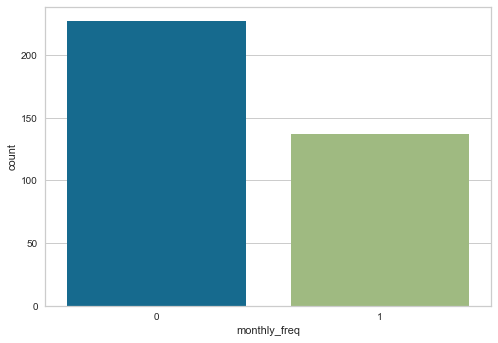

In [562]:
sns.countplot(x = 'monthly_freq', data = stations_df0)
plt.show()

Aquí se puede observar que la personas con una membresía mensual usan una menor cantidad de las estaciones para salir, lo que pude significar que están concentrados en zonas bastante específicas.

In [366]:
colors = list(stations_df0['monthly_freq'])

for i in range(len(colors)):
    if colors[i] == 1:
        colors[i] = 'blue'
    else:
        colors[i] = 'red'

In [367]:
m = folium.Map(location = [34.025841, -118.238213], zoom_start = 12, tiles = "Stamen Terrain")



for i, station in enumerate(stations0):
      folium.Marker( [lats[i], lons[i]], 
                popup = 'Station ' + str(stations0[i]), 
                icon = folium.Icon(color = colors[i])
                ).add_to(m)
m

En el mapa podemos observar que efectivamente los usuarios de membresías diferentes a la mensual, se encuentran completamente dispersos en toda la zona, mientras que aquellos usuarios con membresías mensuales parecieran aglomerarse en ciertos puntos. Estos puntos pueden ser centros educativos o empresas.

In [563]:
stations = list(df_eda['end_station'].unique())
lats = []
lons = []
counts_monthly = []
counts_no_monthly = []

for station in stations:
    lats.append(df_eda[df_eda['end_station'] == station].iloc[0, 4])
    lons.append(df_eda[df_eda['end_station'] == station].iloc[0, 5])
    counts_monthly.append(df_eda[(df_eda['end_station'] == station) & (df_eda['passholder_type'] == 'Monthly Pass')]['end_station'].value_counts().to_list())
    counts_no_monthly.append(df_eda[(df_eda['end_station'] == station) & (df_eda['passholder_type'] != 'Monthly Pass')]['end_station'].value_counts().to_list())

In [564]:
stations_df = pd.DataFrame({
    'lat': lats,
    'lon': lons,
    'station': stations,
    'count_monthly': counts_monthly,
    'count_no_monthly': counts_no_monthly
})

stations_df['count_monthly'] = stations_df['count_monthly'].apply(lambda x: x[0] if len(x) != 0 else 0)
stations_df['count_no_monthly'] = stations_df['count_no_monthly'].apply(lambda x: x[0] if len(x) != 0 else 0)
stations_df['monthly_freq'] = stations_df['count_monthly'] - stations_df['count_no_monthly']
stations_df['monthly_freq'] = stations_df['monthly_freq'].apply(lambda x: 1 if x > 0 else 0)
stations_df

,lat,lon,station,count_monthly,count_no_monthly,monthly_freq
0,33.748920,-118.275192,4127,110,89,1
1,34.035679,-118.270813,3062,4475,2047,1
2,34.062580,-118.290092,4311,755,419,1
3,34.026291,-118.277687,4443,412,188,1
4,34.135250,-118.132370,4158,455,316,1
...,...,...,...,...,...,...
364,34.029121,-118.403168,4327,0,1,0
365,34.011992,-118.453243,4362,0,1,0
366,34.025860,-118.284103,4468,1,1,0
367,34.036770,-118.425377,4373,2,1,1


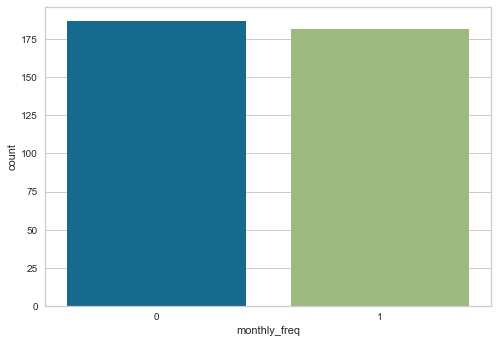

In [566]:
sns.countplot(x = 'monthly_freq', data = stations_df)
plt.show()

En este caso observamos una cantidad similar para ambas categorías en el caso de las estaciones de llegada, vemos una disminución en las estaciones usadas de llegada por  parte del resto de membresías y un aumento en el caso de la membresía mensual. Esto significa que en el primer caso, estos se concentran en lugares específicos al llegar a su destino mientras que se dispersan los poseedores de una membresía mensual.

In [567]:
colors = list(stations_df['monthly_freq'])

for i in range(len(colors)):
    if colors[i] == 1:
        colors[i] = 'blue'
    else:
        colors[i] = 'red'
        

In [568]:
m = folium.Map(location = [34.025841, -118.238213], zoom_start = 12, tiles = "Stamen Terrain")



for i, station in enumerate(stations):
      folium.Marker( [lats[i], lons[i]], 
                popup = 'Station ' + str(stations[i]) , 
                icon = folium.Icon(color = colors[i])
                ).add_to(m)
m

En este caso no vemos concentraciones específicas de aquellos con membresía mensual, si no que se encuentran dispersos la igual que su contraparte.

Analicemos un poco más, el uso de las estaciones.

## Data Cleaning

### Missing Values

In [569]:
df_eda.isnull().sum() / len(df) * 100

trip_id                0.000000
duration               0.000000
start_time             0.000000
end_time               0.000000
start_lat              0.000000
start_lon              0.000000
end_lat                0.000000
end_lon                0.000000
bike_id                0.000000
plan_duration          0.029714
trip_route_category    0.000000
passholder_type        0.368000
start_station          0.000000
end_station            0.000000
year                   0.000000
month                  0.000000
day_of_week            0.000000
hour_of_day            0.000000
dtype: float64

In [570]:
df_eda['passholder_type'].value_counts()

Monthly Pass    394769
Walk-up         212426
One Day Pass     44455
Annual Pass      34092
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

Al igual que en el caso de las coordenadas, los valores nulos que se encuentran en la columna *passholder_type* se encuentran correctos en la columna *plan_duration* y viceversa.

In [572]:
df_eda[df_eda['passholder_type'].isnull()]['plan_duration'].unique()

array([30.])

In [573]:
df_eda['passholder_type'].fillna('Monthly Pass', inplace = True)

In [574]:
df_eda['passholder_type'].value_counts()

Monthly Pass    397345
Walk-up         212426
One Day Pass     44455
Annual Pass      34092
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

In [575]:
df_eda[df_eda['plan_duration'].isnull()]['passholder_type'].unique()

array(['Monthly Pass'], dtype=object)

In [576]:
df_eda['plan_duration'].fillna(30., inplace = True)

In [577]:
df_eda.isnull().sum() / len(df) * 100

trip_id                0.0
duration               0.0
start_time             0.0
end_time               0.0
start_lat              0.0
start_lon              0.0
end_lat                0.0
end_lon                0.0
bike_id                0.0
plan_duration          0.0
trip_route_category    0.0
passholder_type        0.0
start_station          0.0
end_station            0.0
year                   0.0
month                  0.0
day_of_week            0.0
hour_of_day            0.0
dtype: float64

### Outliers

In [389]:
df_eda['duration'].describe()

count    700000.000000
mean         37.084979
std         125.302510
min           1.000000
25%           7.000000
50%          13.000000
75%          26.000000
max        1440.000000
Name: duration, dtype: float64

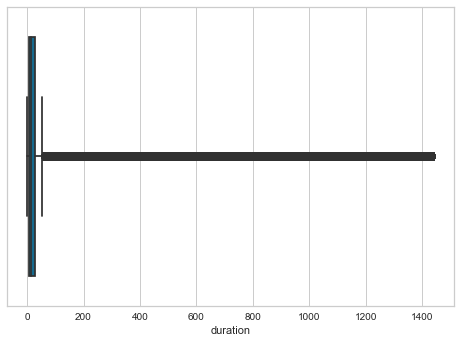

In [390]:
sns.boxplot( df_eda['duration'] )
plt.show()

Existe una gran cantidad de datos atípicos en la variable *duration*, estos serán tratados con el método Quantile-based Flooring.

**Quantile-based Flooring and Capping**

In [391]:
df_eda['duration'].quantile(0.10) , df_eda['duration'].quantile(0.90)

(4.0, 59.0)

In [392]:
df_eda['duration'].where(df_eda['duration'] >= 4., 4, inplace = True)
df_eda['duration'].where(df_eda['duration'] <= 59., 59., inplace = True)

## Data Preparation

A continuación se obtendrá la distancia entre los puntos de salida y llegada a partir de las coordenadas.

In [393]:
# Funciones para calcular la distancia entre dos puntos sobre el planeta Tierra
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

In [582]:
lat_lon_df = df_eda[['start_lat', 'start_lon', 'end_lat', 'end_lon']]
lat_lon_df = lat_lon_df.assign(distance = lambda row: dummy_manhattan_distance(row['start_lat'], row['start_lon'], row['end_lat'], row['end_lon']) )

In [583]:
df_eda['distance'] = lat_lon_df['distance']

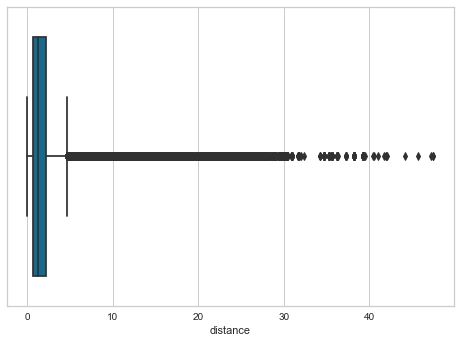

In [584]:
sns.boxplot( df_eda['distance'] )
plt.show()

Observamos una gran cantidad de puntos atípicos que serán tratados igual que antes.

In [585]:
df_eda['distance'].quantile(0.10) , df_eda['distance'].quantile(0.90)

(0.0, 3.618447068172667)

In [586]:
df_eda['distance'].where(df_eda['distance'] <= 3.7, 3.7, inplace = True)

Obtendremos dos variables categorícas a partir de las variables númericas *distance* y *duration*.

In [587]:
def distance(x):
    if x <= 0.3:
        return 'short'
    elif x > 0.3 and x <= 2:
        return 'medium'
    else:
        return 'large'

# categoría de distance
df_eda['distance_cat'] = df_eda['distance'].apply(distance)

In [588]:
# Categoría de duration
df_eda['duration_cat'] = df_eda['duration'].apply(lambda x: 'little' if x <= 20 else 'much')

In [590]:
# Variables que se transformarán a categoricas
categories = ['trip_route_category', 'passholder_type', 'year', 'day_of_week' , 'distance_cat', 'duration_cat',  'month']

# Variables que se eliminarán del modelo
to_drop = ['trip_id', 'start_time', 'end_time', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'bike_id','start_station', 'end_station', 'plan_duration']

In [591]:
for cat in categories:
    df_eda[cat] = df_eda[cat].astype('category')

In [592]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_id              700000 non-null  int64         
 1   duration             700000 non-null  int64         
 2   start_time           700000 non-null  datetime64[ns]
 3   end_time             700000 non-null  datetime64[ns]
 4   start_lat            700000 non-null  float64       
 5   start_lon            700000 non-null  float64       
 6   end_lat              700000 non-null  float64       
 7   end_lon              700000 non-null  float64       
 8   bike_id              700000 non-null  object        
 9   plan_duration        700000 non-null  float64       
 10  trip_route_category  700000 non-null  category      
 11  passholder_type      700000 non-null  category      
 12  start_station        700000 non-null  int64         
 13  end_station   

In [593]:
# Creación de dataset para el modelo predictivo
df_model = df_eda.drop(to_drop, axis = 1)

In [594]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   duration             700000 non-null  int64   
 1   trip_route_category  700000 non-null  category
 2   passholder_type      700000 non-null  category
 3   year                 700000 non-null  category
 4   month                700000 non-null  category
 5   day_of_week          700000 non-null  category
 6   hour_of_day          700000 non-null  int64   
 7   distance             700000 non-null  float64 
 8   distance_cat         700000 non-null  category
 9   duration_cat         700000 non-null  category
dtypes: category(7), float64(1), int64(2)
memory usage: 20.7 MB


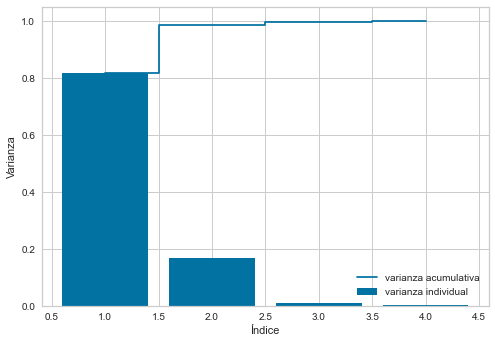

In [595]:
# Debido a que las coordenadas geográficas contienen una gran cantidad de ruido, procederemos a transformarlas mediante PCA
coords = df_eda[['start_lat', 'start_lon', 'end_lat', 'end_lon']]

cov_mat = np.cov(coords.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [ev / tot for ev in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1, 5), var_exp, label = 'varianza individual', align = 'center')
plt.step(range(1, 5), cum_var_exp, where = 'mid', label = 'varianza acumulativa')
plt.xlabel('Índice')
plt.ylabel('Varianza')
plt.legend(loc = 'best')
plt.show()

En la gráfica podemos observar que tres componentes serían suficientes, pues contendrían casi el 100% de la información, sin embargo, queremos dejarlo de la misma dimensionalidad, por lo que seleccionaremos 4.

In [596]:
pca_geo = PCA(n_components = 4, random_state = 42)
coords = pca_geo.fit_transform(coords)

In [597]:
df_model['geo_1'] = coords[:, 0]
df_model['geo_2'] = coords[:, 1]
df_model['geo_3'] = coords[:, 2]
df_model['geo_4'] = coords[:, 3]

In [599]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   duration             700000 non-null  int64   
 1   trip_route_category  700000 non-null  category
 2   passholder_type      700000 non-null  category
 3   year                 700000 non-null  category
 4   month                700000 non-null  category
 5   day_of_week          700000 non-null  category
 6   hour_of_day          700000 non-null  int64   
 7   distance             700000 non-null  float64 
 8   distance_cat         700000 non-null  category
 9   duration_cat         700000 non-null  category
 10  geo_1                700000 non-null  float64 
 11  geo_2                700000 non-null  float64 
 12  geo_3                700000 non-null  float64 
 13  geo_4                700000 non-null  float64 
dtypes: category(7), float64(5), int64(2)
memory usage: 4

In [604]:
# Transformaremos la variable target mediante un etiquetado
le = LabelEncoder()
le.fit(df_model['passholder_type'])
df_model['passholder_type_cat'] =  le.transform( df_model['passholder_type'])

In [605]:
df_model['passholder_type_cat'].unique()

array([5, 2, 3, 0, 1, 4])

In [415]:
le.inverse_transform([5, 2, 3, 0, 1, 4])

array(['Walk-up', 'Monthly Pass', 'One Day Pass', 'Annual Pass',
       'Flex Pass', 'Testing'], dtype=object)

La categoria de nuestro interés es la assignada como etiqueta 2.

In [606]:
# Obtención de variables Dummies de las variables categóricas
df_model_dummies = df_model.drop(['passholder_type'], axis = 1)
df_model_dummies = pd.get_dummies(df_model_dummies, drop_first = True)

In [607]:
df_model_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   duration                        700000 non-null  int64  
 1   hour_of_day                     700000 non-null  int64  
 2   distance                        700000 non-null  float64
 3   geo_1                           700000 non-null  float64
 4   geo_2                           700000 non-null  float64
 5   geo_3                           700000 non-null  float64
 6   geo_4                           700000 non-null  float64
 7   passholder_type_cat             700000 non-null  int32  
 8   trip_route_category_Round Trip  700000 non-null  uint8  
 9   year_2017                       700000 non-null  uint8  
 10  year_2018                       700000 non-null  uint8  
 11  year_2019                       700000 non-null  uint8  
 12  year_2020       

In [608]:
# Escritura de los datos
df_model_dummies.to_csv('./df_model_dummies.csv')
print('File Saved')

File Saved


In [2]:
# Lectura de los datos, en caso de ser necesario
# df_model_dummies = pd.read_csv('./df_model_dummies.csv')
# df_model_dummies.drop('Unnamed: 0', axis = 1, inplace = True)
# print('File Opened')

In [622]:
# Las columnas iniciales consideradas para el modelo son:
features = df_model_dummies.drop('passholder_type_cat', axis = 1).columns
features

Index(['duration', 'hour_of_day', 'distance', 'geo_1', 'geo_2', 'geo_3',
       'geo_4', 'trip_route_category_Round Trip', 'year_2017', 'year_2018',
       'year_2019', 'year_2020', 'year_2021', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'distance_cat_medium', 'distance_cat_short', 'duration_cat_much'],
      dtype='object')

In [623]:
X = df_model_dummies.drop('passholder_type_cat', axis = 1).values
y = df_model_dummies['passholder_type_cat'] # La variable target será passholder_type_cat es decir, passholder_type transformada a etiqueta

In [624]:
X.shape, y.shape

((700000, 33), (700000,))

Dado que se tiene una gran cantidad de información seleccionaremos una muestra de manera aleatoria para entrenar nuestro modelo, el resto servirá para hacer una simulación y medir la eficiencia del modelo en datos que nunca ha visto.

In [625]:
X_simulation, X_new, y_simulation, y_new = train_test_split(X, y, test_size = 0.075, stratify = y, random_state = 42)

In [626]:
X_simulation.shape, X_new.shape

((647500, 33), (52500, 33))

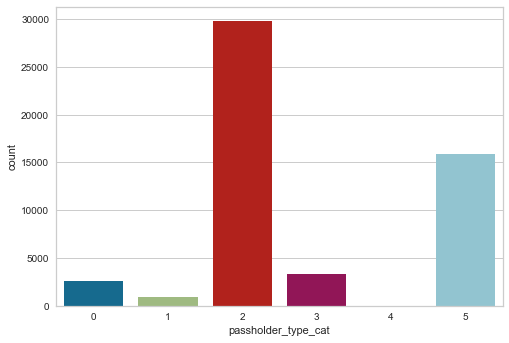

In [627]:
sns.countplot(y_new)
plt.show()

Claramente hay una desbalanceo en las categorías, por lo que utilizaremos una técnica de oversampling.

In [628]:
%%time
smote = SMOTE(random_state = 42, n_jobs = -1)
X_over, y_over = smote.fit_resample(X_new, y_new)

Wall time: 7.18 s


In [629]:
X_over.shape

(178806, 33)

## Feature Selection

In [630]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, stratify = y_over)

Dado que se crearon muchas variables puede existir redundancia en ellas, para evitarlo usaremos una técnica de selección de variables iterativa, mediante RandomForest.

In [631]:
%%time
rfe = RFE(RandomForestClassifier(random_state = 42), n_features_to_select = 28)
rfe.fit(X_train, y_train)
print('Features Selected')

Features Selected
Wall time: 3min 35s


In [632]:
# Guardamos el modelo
joblib.dump(rfe, './MODELS/selection.pkl')
print('Model Saved')

Model Saved


In [8]:
# Lectura del modelo en caso de ser necesario
# rfe = joblib.load('./MODELS/selection.pkl')

In [633]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [716]:
selected_features = []
for i in range(X_over.shape[1]):
    if rfe.support_[i]:
        print(features[i])
        selected_features.append(features[i])

duration
hour_of_day
distance
geo_1
geo_2
geo_3
geo_4
trip_route_category_Round Trip
year_2017
year_2018
year_2019
year_2020
year_2021
month_3
month_4
month_5
month_6
month_10
month_12
day_of_week_1
day_of_week_2
day_of_week_3
day_of_week_4
day_of_week_5
day_of_week_6
distance_cat_medium
distance_cat_short
duration_cat_much


Observamos que las variables númericas que se crearon, fueron consideradas importantes dentro del modelo, sin embargo se eliminaron algunas categóricas creadas como variables dummies.

## Modeling

### Baseline

In [635]:
%%time
print(datetime.now().time())

lr = LogisticRegression(max_iter = 10000)
lr.fit(X_train_rfe, y_train)
y_pred = lr.predict(X_test_rfe)
accuracy_score(y_test,y_pred)

11:28:11.454793
Wall time: 10min 15s
Parser   : 108 ms


0.6090749785615749

Es un score relativamente malo, y fué un tiempo bastante largo, por lo que se probarán métodos ensemble.

### Advanced Models

In [636]:
%%time
print(datetime.now().time())

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_rfe, y_train)
y_pred = rf.predict(X_test_rfe)
rf.score(X_test_rfe, y_test)

11:39:16.566280
Wall time: 39.7 s


0.8785839454159055

In [ ]:
%%time
print(datetime.now().time())

gb = GradientBoostingClassifier()
gb.fit(X_train_rfe, y_train)
y_pred = gb.predict(X_test_rfe)
gb.score(X_test_rfe, y_test)

In [639]:
%%time
print(datetime.now().time())

xgb = XGBClassifier(eval_metric = 'logloss')
xgb.fit(X_train_rfe, y_train)
y_pred = xgb.predict(X_test_rfe)
xgb.score(X_test_rfe, y_test)

11:45:53.877577
Wall time: 41.6 s


0.8427165280936579

### Hyperparameters 

In [640]:
params1 = {
        'max_depth':range(5, 14, 2),
         'min_child_weight':[6, 7]
        }


In [641]:
%%time
print(datetime.now().time())

grid = GridSearchCV(estimator = XGBClassifier(eval_metric = 'logloss'),
                param_grid = params1,
                scoring = 'accuracy',
                cv = 10,
                verbose = 4)

grid.fit(X_train_rfe, y_train)

11:47:14.178929
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END ..max_depth=5, min_child_weight=6;, score=0.825 total time=  33.0s
[CV 2/10] END ..max_depth=5, min_child_weight=6;, score=0.827 total time=  34.9s
[CV 3/10] END ..max_depth=5, min_child_weight=6;, score=0.830 total time=  33.9s
[CV 4/10] END ..max_depth=5, min_child_weight=6;, score=0.821 total time=  33.4s
[CV 5/10] END ..max_depth=5, min_child_weight=6;, score=0.823 total time=  34.0s
[CV 6/10] END ..max_depth=5, min_child_weight=6;, score=0.822 total time=  33.9s
[CV 7/10] END ..max_depth=5, min_child_weight=6;, score=0.827 total time=  34.1s
[CV 8/10] END ..max_depth=5, min_child_weight=6;, score=0.820 total time=  39.0s
[CV 9/10] END ..max_depth=5, min_child_weight=6;, score=0.826 total time=  38.6s
[CV 10/10] END .max_depth=5, min_child_weight=6;, score=0.823 total time=  33.7s
[CV 1/10] END ..max_depth=5, min_child_weight=7;, score=0.819 total time=  34.2s
[CV 2/10] END ..max_depth=5, m

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
         

In [642]:
grid.best_params_

{'max_depth': 13, 'min_child_weight': 6}

In [643]:
clf = grid.best_estimator_

In [644]:
joblib.dump(clf, './MODELS/classifier.pkl')

['./MODELS/classifier.pkl']

In [114]:
clf = joblib.load('./MODELS/classifier.pkl')

In [645]:
clf.score(X_test_rfe, y_test)

0.8881659893367138

In [646]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=13, min_child_weight=6, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

### Model Evaluation

#### Stratified k-fold CV

In [649]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, 
                        random_state=42).split(X_test_rfe,y_test)

In [651]:
scores = []

for k, (train,test) in enumerate(kfold):
    clf.fit(X_test_rfe[train], np.array(y_test)[train])
    score = clf.score(X_test_rfe[test], np.array(y_test)[test])
    scores.append(score)
    
    print("Fold #{}, Tamaño:{}, Acc:{}".format(k+1, 
                                           np.bincount(np.array(y_test)[train]), 
                                               score))
    
print("Mean Acc CV: {} +/- {}".format(np.mean(scores), np.std(scores)))


Fold #1, Tamaño:[8047 8046 8046 8046 8046 8046], Acc:0.8430568499534017
Fold #2, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8542132736763609
Fold #3, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8473154362416108
Fold #4, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8540268456375839
Fold #5, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8581282624906786
Fold #6, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8435868754660701
Fold #7, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8489932885906041
Fold #8, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8465697240865027
Fold #9, Tamaño:[8047 8046 8046 8046 8046 8047], Acc:0.8463832960477256
Mean Acc CV: 0.849141539132282 +/- 0.004896783593324223


#### Simulation set

A continuación pondremos a prueba el modelo seleccionado sobre el resto de las filas no usadas en el entrenamiento.

In [652]:
X_simulation.shape

(647500, 33)

In [656]:
X_simulation_rfe = rfe.transform(X_simulation)

In [657]:
y_pred = clf.predict(X_simulation_rfe)

In [658]:
accuracy_score(y_simulation, y_pred)

0.6689590733590733

Definitivamente es un modelo que puede mejorarse, cosiderando la creación de nuevos features mediante la ubicación. También es un modelo que puede ser mejorado mediante la colección de más datos, considerando cuestiones demográficas, por ejemplo o incluso socieconómicas del usuario. Otra manera de mejorar el score es intentando probar modelos con herramientas de big data como PySpark o con un mayor poder computacional que permita tomar un conjunto de entrenamiento mucho más grande.